In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from os import path
from linear_opt.lin_metabolism import LinearMetabolicModel

from SALib import ProblemSpec

In [2]:
model_dir = '../models/linear/respiration/'
m_fname = path.join(model_dir, 'glucose_resp_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_resp_stoich_matrix.csv')
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)

In [3]:
# Do a quick run of the model to make sure it is feasible
p = lam.max_anabolic_rate_problem(maint=1e-5)
res = p.solve(verbose=True)
p.value

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jul 12 11:59:53 AM: Your problem has 4 variables, 2 constraints, and 18 parameters.
(CVXPY) Jul 12 11:59:53 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 12 11:59:53 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 12 11:59:53 AM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 12 11:59:53 AM: Reduction chain: EvalParams -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Jul 12 11:59:53 AM: Applying reduction EvalParams
(CVXPY) Jul 12 11:59:53 AM: Applying 

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


0.00037462499402273033

In [4]:
p = lam.max_anabolic_rate_problem(phi_o=0.4, fix_lambda=True)
phis = []
lambdas = np.arange(0.1, 1.501, 0.01)

for lam_val in lambdas:
    p.param_dict['lambda_hr'].value = lam_val
    res = p.solve()
    if p.status in ("infeasible", "unbounded"):
        phis.append(np.zeros(lam.S_df.index.size + 1))
        continue
    phis.append(p.var_dict['phis'].value.tolist() + [p.param_dict['phi_o'].value])    

colnames = lam.S_df.index.values.tolist() + ['other']
phi_df = pd.DataFrame(phis, columns=colnames)
phi_df['lambda_hr'] = lambdas
phi_df.set_index('lambda_hr', inplace=True)
phi_df.head()

,oxidation,reduction,anabolism,ATP_homeostasis,other
lambda_hr,,,,,
0.10,0.059064,0.236257,0.055556,0.249123,0.4
0.11,0.058655,0.234620,0.061111,0.245614,0.4
0.12,0.058246,0.232982,0.066667,0.242105,0.4
0.13,0.057836,0.231345,0.072222,0.238596,0.4
0.14,0.057427,0.229708,0.077778,0.235088,0.4


Text(0, 0.5, '$\\phi$')

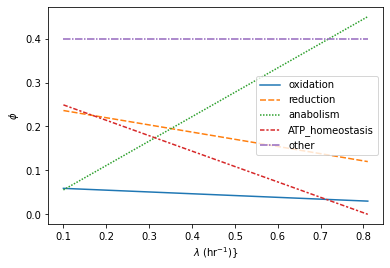

In [5]:
mask = (phi_df != 0).all(axis=1)
sns.lineplot(data=phi_df[mask])
plt.xlabel(r'$\lambda$ (hr$^{-1}$)}')
plt.ylabel(r'$\phi$')   

In [6]:
# Use the SAlib tools to generate parameters for a sensitivity analysis
ps = ProblemSpec({
        "names": ["phi_o", "S6", "m_resp", "resp_ATP_per_e", "m_ATP_homeostasis"],
        "groups": None,
        "bounds": [[0.3, 0.5], [-0.5, 0.5], [10, 10000], [0.2, 2], [10, 10000],],
        "outputs": ["lambda_max"],
    })
ps.sample_sobol(64)

# Store the results in a dictionary for making a dataframe
res_dict = dict(ZCB=[], S6=[], phi_O=[], lambda_max=[], m_resp=[],
                resp_ATP_per_e=[], m_ATP_homeostasis=[])
for p in list(lam.processes) + ['other']:
    res_dict['{0}_phi'.format(p)] = []
    res_dict['{0}_flux'.format(p)] = []

for phi_o, s6, m_resp, atp_per_e, m_homeo in ps.samples:
    lam.set_S6(s6)
    lam.set_process_mass('reduction', m_resp)
    lam.set_process_mass('ATP_homeostasis', m_homeo)
    lam.set_ATP_yield('reduction', atp_per_e)
    max_lam, opt_prob = lam.maximize_lambda(phi_o=phi_o)

    res_dict['ZCB'].append(lam.ZCB)
    res_dict['S6'].append(s6)
    res_dict['phi_O'].append(phi_o)
    res_dict['m_resp'].append(m_resp)
    res_dict['resp_ATP_per_e'].append(atp_per_e)
    res_dict['m_ATP_homeostasis'].append(m_homeo)

    if max_lam == 0:
        res_dict['lambda_max'].append(0)
        for k, process in enumerate(lam.processes):
            res_dict['{0}_phi'.format(process)].append(np.NaN)
            res_dict['{0}_flux'.format(process)].append(np.NaN)
        res_dict['other_phi'].append(np.NaN)
        res_dict['other_flux'].append(np.NaN)
    else:
        res_dict['lambda_max'].append(max_lam)

        phis = opt_prob.var_dict['phis'].value.copy()
        js = 3600*phis*lam.kcat_s/lam.m_Da
        for k, process in enumerate(lam.processes):
            res_dict['{0}_phi'.format(process)].append(phis[k])
            res_dict['{0}_flux'.format(process)].append(js[k])
        res_dict['other_phi'].append(phis[-1])
        res_dict['other_flux'].append(np.NaN)

res_df = pd.DataFrame(res_dict)
res_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


,ZCB,S6,phi_O,lambda_max,m_resp,resp_ATP_per_e,m_ATP_homeostasis,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,ATP_homeostasis_phi,ATP_homeostasis_flux,other_phi,other_flux
0,0.621534,-0.310767,0.463864,0.029566,742.052343,1.043345,7756.059909,3.482183e-09,6.267930e-09,0.075757,0.018376,0.016426,0.029566,0.443953,1.030311e-02,0.443953,NaN
1,0.621534,-0.310767,0.491391,0.028048,742.052343,1.043345,7756.059909,2.045314e-09,3.681566e-09,0.071868,0.017433,0.015582,0.028048,0.421159,9.774114e-03,0.421159,NaN
2,0.212511,-0.106256,0.463864,0.312221,742.052343,1.043345,7756.059909,2.905344e-03,5.229620e-03,0.359768,0.087269,0.173456,0.312221,0.000006,1.502992e-07,0.000006,NaN
3,0.621534,-0.310767,0.463864,0.010875,9767.919168,1.043345,7756.059909,3.277223e-10,5.899001e-10,0.366799,0.006759,0.006042,0.010875,0.163295,3.789698e-03,0.163295,NaN
4,0.621534,-0.310767,0.463864,0.012442,742.052343,1.975297,7756.059909,1.821919e-09,3.279455e-09,0.031879,0.007733,0.006912,0.012442,0.497345,1.154222e-02,0.497345,NaN


In [7]:
ps.set_results(res_df.lambda_max.values)
ps.analyze_sobol(print_to_console=True, calc_second_order=True)

                         ST   ST_conf
phi_o              0.012724  0.010772
S6                 0.427633  0.358868
m_resp             0.862627  0.429502
resp_ATP_per_e     0.256090  0.221395
m_ATP_homeostasis  0.060167  0.132789
                         S1   S1_conf
phi_o              0.012675  0.031717
S6                 0.176015  0.153107
m_resp             0.982590  0.594324
resp_ATP_per_e     0.128173  0.117378
m_ATP_homeostasis  0.030186  0.058456
                                           S2   S2_conf
(phi_o, S6)                         -0.040927  0.051340
(phi_o, m_resp)                      0.047572  0.120463
(phi_o, resp_ATP_per_e)             -0.026018  0.058660
(phi_o, m_ATP_homeostasis)          -0.018256  0.046349
(S6, m_resp)                         0.077063  0.350250
(S6, resp_ATP_per_e)                -0.031450  0.153725
(S6, m_ATP_homeostasis)             -0.110094  0.136268
(m_resp, resp_ATP_per_e)            -0.591698  0.957057
(m_resp, m_ATP_homeostasis)         -0.4

{'names': ['phi_o', 'S6', 'm_resp', 'resp_ATP_per_e', 'm_ATP_homeostasis'],
 'groups': None,
 'bounds': [[0.3, 0.5], [-0.5, 0.5], [10, 10000], [0.2, 2], [10, 10000]],
 'outputs': ['lambda_max'],
 'num_vars': 5,
 'sample_scaled': True}

<AxesSubplot: xlabel='m_resp', ylabel='lambda_max'>

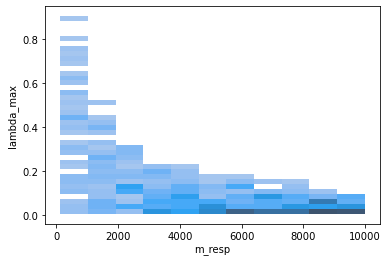

In [8]:
sns.histplot(data=res_df, y='lambda_max', x='m_resp', legend=False)

In [9]:
mask = np.logical_and(res_df.lambda_max > 0.01, res_df.m_ATP_homeostasis > 500)
cols = 'ZCB,S6,phi_O,m_resp,resp_ATP_per_e,m_ATP_homeostasis,lambda_max,anabolism_phi'.split(',')
res_df[mask][cols].sort_values('lambda_max', ascending=False)

,ZCB,S6,phi_O,m_resp,resp_ATP_per_e,m_ATP_homeostasis,lambda_max,anabolism_phi
440,-0.520516,0.260258,0.340727,131.916023,1.881446,7387.556041,0.903205,0.501780
343,0.130932,-0.065466,0.385895,148.756011,1.267116,8322.383994,0.811506,0.450836
346,-0.976750,0.488375,0.385895,148.756011,1.267116,4281.667098,0.753891,0.418828
347,-0.976750,0.488375,0.385895,148.756011,1.267116,8322.383994,0.753890,0.418828
447,-0.267076,0.133538,0.355020,246.976941,1.345991,1471.170976,0.744337,0.413520
...,...,...,...,...,...,...,...,...
579,0.990507,-0.495254,0.461494,5971.866757,0.800885,6231.208630,0.010665,0.005925
76,0.801102,-0.400551,0.309289,9309.625278,1.584657,4430.612763,0.010489,0.005827
221,0.948885,-0.474442,0.382206,1331.646378,1.380115,9375.580341,0.010269,0.005705
124,0.742707,-0.371354,0.366931,5035.551369,1.744974,7430.396911,0.010137,0.005632


/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


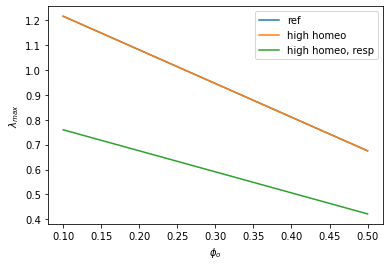

In [10]:
ref_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)

high_homeo_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
high_homeo_lam.set_process_mass('ATP_homeostasis', 400) # 4x baseline

high_homeo_resp_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
high_homeo_resp_lam.set_process_mass('ATP_homeostasis', 400) # 4x baseline
high_homeo_resp_lam.set_process_mass('reduction', 400) # 4x baseline

phi_os = np.arange(0.1, 0.501, 0.1)
ref_lambdas = [ref_lam.maximize_lambda(phi_o=p)[0] for p in phi_os]
high_homeo_lambdas = [high_homeo_lam.maximize_lambda(phi_o=p)[0] for p in phi_os]
high_homeo_resp_lambdas = [high_homeo_resp_lam.maximize_lambda(phi_o=p)[0] for p in phi_os]

plt.plot(phi_os, ref_lambdas, label='ref')
plt.plot(phi_os, high_homeo_lambdas, label='high homeo')
plt.plot(phi_os, high_homeo_resp_lambdas, label='high homeo, resp')
plt.legend()
plt.xlabel(r'$\phi_o$')
plt.ylabel(r'$\lambda_{max}$')
plt.show()

In [11]:
ZCBs = np.arange(-1, 1.01, 0.05)
phi_os = np.arange(0.1, 0.501, 0.2)
homeo_costs = np.logspace(1, 3, 3)
resp_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 1, 2]

ref_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
res_dict = dict(ZCB=[], phi_o=[], homeo_cost=[], lambda_max=[], S6=[], resp_cost=[], resp_ATP_per_e=[])

for z in ZCBs:
    ref_lam.set_ZCB(z)
    for phi_o in phi_os:
        for homeo_cost in homeo_costs:
            for resp_cost in resp_costs:
                for atp_per_e in ATP_per_es:
                    ref_lam.set_process_mass('reduction', resp_cost)
                    ref_lam.set_process_mass('ATP_homeostasis', homeo_cost)
                    ref_lam.set_ATP_yield('reduction', atp_per_e)
                    m, _ = ref_lam.maximize_lambda(phi_o=phi_o)
                    res_dict['ZCB'].append(z)
                    res_dict['phi_o'].append(phi_o)
                    res_dict['homeo_cost'].append(homeo_cost)
                    res_dict['lambda_max'].append(m)
                    res_dict['S6'].append(ref_lam.get_S6())
                    res_dict['resp_cost'].append(resp_cost)
                    res_dict['resp_ATP_per_e'].append(atp_per_e)
res_df = pd.DataFrame(res_dict)

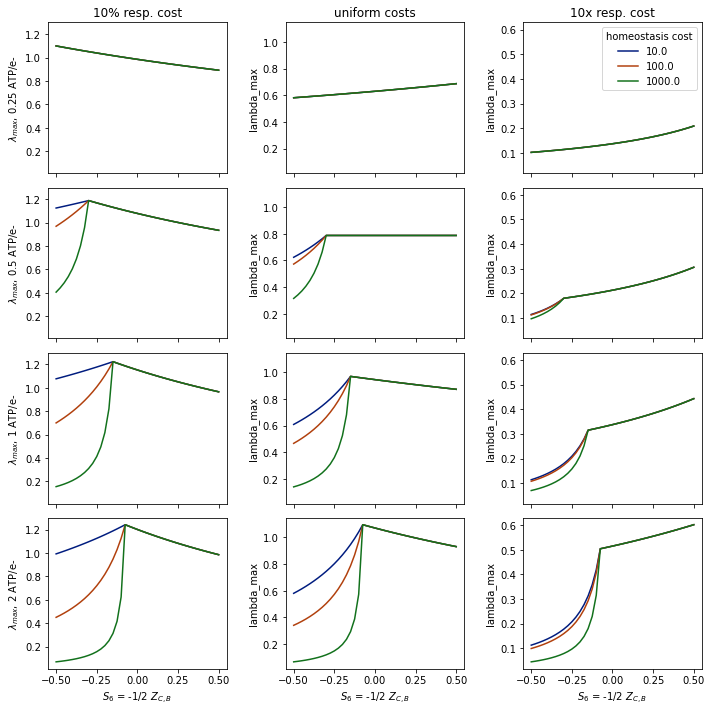

In [12]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey='col')

titles = '10% resp. cost,uniform costs,10x resp. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.resp_cost == resp_cost, res_df.phi_o == phi_os[1])
        mask = np.logical_and(mask, res_df.resp_ATP_per_e == a_per_e)
        sns.lineplot(data=res_df[mask], x='S6', y='lambda_max', hue='homeo_cost', palette='dark')
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\lambda_{{max}}$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend(title='homeostasis cost').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_max_vs_S6.png', dpi=300, facecolor='white')
plt.show()